In [1]:
import pyspark as ps
sc = ps.SparkContext.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 02:35:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
from pyspark.sql import SparkSession
#building a spark session
spark = SparkSession.builder.appName("missingdata").getOrCreate()

In [4]:
df = spark.read.csv("DOB_Job_Application_Filings_20240422.csv",header=True,inferSchema=True)


24/05/06 02:35:55 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
df.head()

24/05/06 02:35:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(Job #=301776077, Doc #=1, Borough='BROOKLYN', House #='208', Street Name='NORTH    8 STREET', Block='02321', Lot='00008', Bin #=3061967, Job Type='A2', Job Status='X', Job Status Descrp='SIGNED OFF', Latest Action Date='11/28/2005', Building Type='OTHERS', Community - Board='301', Cluster=None, Landmarked='N', Adult Estab='N', Loft Board=None, City Owned=None, Little e=None, PC Filed='Y', eFiling Filed=None, Plumbing=None, Mechanical=None, Boiler=None, Fuel Burning=None, Fuel Storage=None, Standpipe=None, Sprinkler=None, Fire Alarm=None, Equipment=None, Fire Suppression=None, Curb Cut=None, Other='X', Other Description='GC', Applicant's First Name='David', Applicant's Last Name='Turner', Applicant Professional Title='RA', Applicant License #='016162', Professional Cert='Y', Pre- Filing Date='04/16/2004', Paid='04/20/2004', Fully Paid='04/20/2004', Assigned=None, Approved='04/20/2004', Fully Permitted='05/12/2004', Initial Cost='$6000.00', Total Est. Fee='$150.30', Fee Status='STAND

In [6]:
df.columns

['Job #',
 'Doc #',
 'Borough',
 'House #',
 'Street Name',
 'Block',
 'Lot',
 'Bin #',
 'Job Type',
 'Job Status',
 'Job Status Descrp',
 'Latest Action Date',
 'Building Type',
 'Community - Board',
 'Cluster',
 'Landmarked',
 'Adult Estab',
 'Loft Board',
 'City Owned',
 'Little e',
 'PC Filed',
 'eFiling Filed',
 'Plumbing',
 'Mechanical',
 'Boiler',
 'Fuel Burning',
 'Fuel Storage',
 'Standpipe',
 'Sprinkler',
 'Fire Alarm',
 'Equipment',
 'Fire Suppression',
 'Curb Cut',
 'Other',
 'Other Description',
 "Applicant's First Name",
 "Applicant's Last Name",
 'Applicant Professional Title',
 'Applicant License #',
 'Professional Cert',
 'Pre- Filing Date',
 'Paid',
 'Fully Paid',
 'Assigned',
 'Approved',
 'Fully Permitted',
 'Initial Cost',
 'Total Est. Fee',
 'Fee Status',
 'Existing Zoning Sqft',
 'Proposed Zoning Sqft',
 'Horizontal Enlrgmt',
 'Vertical Enlrgmt',
 'Enlargement SQ Footage',
 'Street Frontage',
 'ExistingNo. of Stories',
 'Proposed No. of Stories',
 'Existing Heigh

In [7]:
unique_classes_count = df.select('Job Type').distinct().count()
unique_classes_count

8

In [8]:
from pyspark.sql.functions import regexp_replace, col
df = df.withColumn('numeric_cost', regexp_replace(col('Initial Cost'), '\$', '').cast('float'))

In [9]:
min_value = df.selectExpr("min(numeric_cost)").collect()[0][0]
min_value

-33000.0

In [10]:
max_value = df.selectExpr("max(numeric_cost)").collect()[0][0]
max_value

1000000000.0

In [11]:
df = df.filter(col('numeric_cost') >= 0)
df = df.filter(col('numeric_cost') !=1000000000.0)

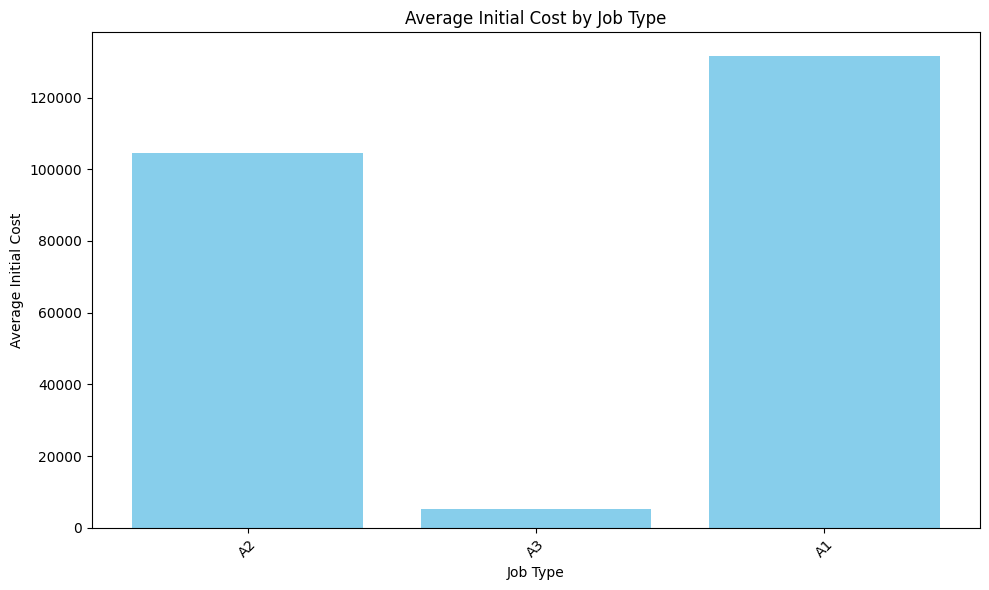

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
avg_cost_by_job_type = df.groupBy('Job Type').avg('numeric_cost')

# Convert the result to Pandas DataFrame for plotting
avg_cost_pd = avg_cost_by_job_type.toPandas()

# Plotting the average cost for different job types
plt.figure(figsize=(10, 6))
plt.bar(avg_cost_pd['Job Type'], avg_cost_pd['avg(numeric_cost)'], color='skyblue')
plt.xlabel('Job Type')
plt.ylabel('Average Initial Cost')
plt.title('Average Initial Cost by Job Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("result_1.png")
plt.show()


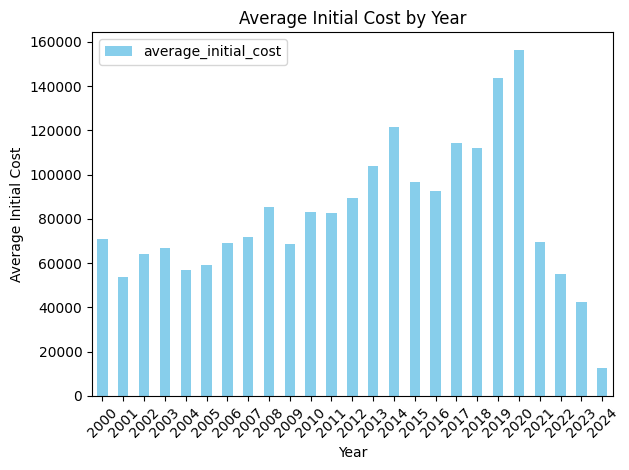

In [50]:
from pyspark.sql.functions import year, regexp_extract, avg
df = df.withColumn('year', regexp_extract('Pre- Filing Date', '(\d+)/\d+/(\d+)', 2))
df =df.orderBy('year')
# Group by year and calculate the average of initial costs
grouped_df = df.groupBy('year').agg(avg('numeric_cost').alias('average_initial_cost'))
pd_df = grouped_df.toPandas()

# Plotting the data using Pandas plot function
pd_df.plot(kind='bar', x='year', y='average_initial_cost', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Average Initial Cost')
plt.title('Average Initial Cost by Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("result_2.png")
plt.show()

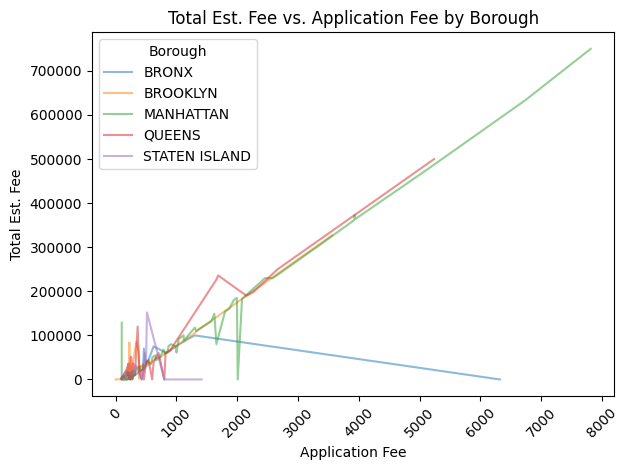

In [51]:
pd_df1 = df.withColumn('estimated_numeric_cost', regexp_replace(col('`Total Est. Fee`'), '\$', '').cast('float'))
pd_df1  = pd_df1 .filter(col('estimated_numeric_cost') <1000000000.0)
pd_df2 = pd_df1.orderBy('estimated_numeric_cost')
sampled_df =pd_df2 .sample(withReplacement=False, fraction=0.01, seed=42)
# Convert Spark DataFrame to Pandas DataFrame
pd_df = sampled_df.toPandas()
grouped_df = pd_df.groupby('Borough')
for name, group in grouped_df:
    plt.plot(group['estimated_numeric_cost'], group['numeric_cost'], label=name, alpha=0.5)

plt.xlabel('Application Fee')
plt.ylabel('Total Est. Fee')
plt.title('Total Est. Fee vs. Application Fee by Borough')
plt.legend(title='Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("result_3.png")
plt.show()

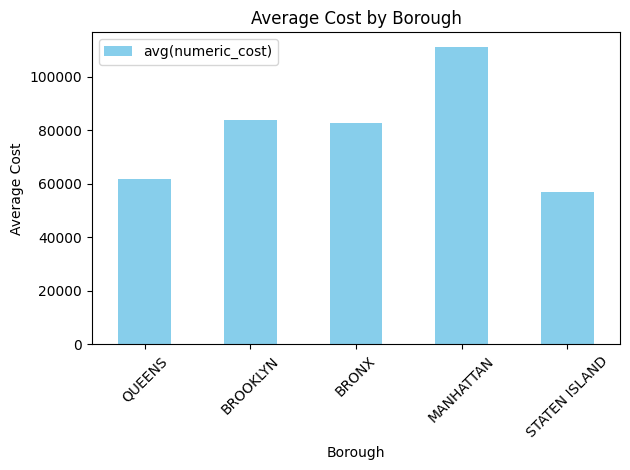

In [52]:
grouped_df = df.groupBy('Borough').avg('numeric_cost')

# Convert Spark DataFrame to Pandas DataFrame
pd_df = grouped_df.toPandas()

# Plotting the data using Pandas plot function
pd_df.plot(kind='bar', x='Borough', y='avg(numeric_cost)', color='skyblue')
plt.xlabel('Borough')
plt.ylabel('Average Cost')
plt.title('Average Cost by Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("result_4.png")
plt.show()

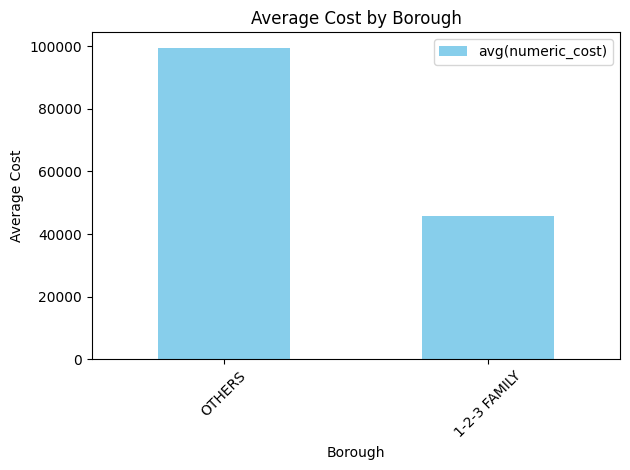

In [53]:
grouped_df = df.groupBy('Building Type').avg('numeric_cost')

# Convert Spark DataFrame to Pandas DataFrame
pd_df = grouped_df.toPandas()

# Plotting the data using Pandas plot function
pd_df.plot(kind='bar', x='Building Type', y='avg(numeric_cost)', color='skyblue')
plt.xlabel('Borough')
plt.ylabel('Average Cost')
plt.title('Average Cost by Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("result_5.png")
plt.show()

In [17]:
#filter all the job type with constructio cost of 0
df = df.filter(col('Job Type') !='SC')
df = df.filter(col('Job Type') !='PA')
df = df.filter(col('Job Type') !='DM')
df = df.filter(col('Job Type') !='SI')
df = df.filter(col('Job Type') !='NB')

In [18]:
#classify all jobs into different groups with their construction cost in different ranges
max_value = df.selectExpr("max(numeric_cost)").collect()[0][0]
max_value

966331776.0

In [19]:
min_value = df.selectExpr("min(numeric_cost)").collect()[0][0]
min_value

0.0

In [20]:
df = df.filter(col('numeric_cost') <4000000)

In [21]:
max_value = df.selectExpr("max(numeric_cost)").collect()[0][0]
max_value
df =df .sample(withReplacement=False, fraction=0.01, seed=42)

In [41]:
from pyspark.ml.feature import Bucketizer, VectorAssembler,StringIndexer,OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
boundaries = [-float("inf"), 500, 1000, 5000, 10000, 200000, 1000000, 4000000, float("inf")]

In [42]:
bucketizer = Bucketizer(splits=boundaries, inputCol="numeric_cost", outputCol="construction_cost_range")

In [43]:
from pyspark.sql.functions import col, when
from pyspark.ml.regression import RandomForestRegressor
pipeline_bucketizer = Pipeline(stages=[bucketizer])

# Fit and transform the data
transformed_df = pipeline_bucketizer.fit(df).transform(df)

# Define the groups
transformed_df = transformed_df.withColumn(
    "construction_cost_group",
    when(col("construction_cost_range") == 0, 1)\
    .when(col("construction_cost_range") == 1, 2)\
    .when(col("construction_cost_range") == 2, 3)\
    .when(col("construction_cost_range") == 3, 4)\
    .when(col("construction_cost_range") == 4, 5)\
    .when(col("construction_cost_range") == 5, 6)\
    .when(col("construction_cost_range") == 6, 7)\
    .when(col("construction_cost_range") == 7, 8)
)

In [44]:
# Display the transformed DataFrame
transformed_df.select("numeric_cost", "construction_cost_group").show()

+------------+-----------------------+
|numeric_cost|construction_cost_group|
+------------+-----------------------+
|      5000.0|                      4|
|     15000.0|                      5|
|     40000.0|                      5|
|     16000.0|                      5|
|      3000.0|                      3|
|       600.0|                      2|
|      7000.0|                      4|
|      2000.0|                      3|
|      1000.0|                      3|
|         0.0|                      1|
|      3500.0|                      3|
|      2000.0|                      3|
|     55000.0|                      5|
|     30000.0|                      5|
|     25000.0|                      5|
|         0.0|                      1|
|     20000.0|                      5|
|      1000.0|                      3|
|     75000.0|                      5|
|      5000.0|                      4|
+------------+-----------------------+
only showing top 20 rows



In [36]:
categorical_cols = ['Job Type', 'Building Type', 'Borough']
target = 'construction_cost_group'

In [45]:
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]

# OneHotEncoder to convert indices into binary vectors
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_cols]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col+"_encoded" for col in categorical_cols], outputCol="features")

# Instantiate Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol=target, numTrees=100)

# Pipeline including all the stages
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Split the data into training and testing sets
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

In [47]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.19868
